## 环境搭建

In [ ]:
# if windows power shell, then execute the following
# python -m venv virtualenv
# virtualenv/Scripts/activate

# if linux shell, then execute the following
# python3 -m venv virtualenv
# source virtualenv/bin/activate

# and anyway, then
# pip install -r requirements.txt

In [ ]:
# 下载数据集
# https://tianchi.aliyun.com/competition/entrance/531830/information

## 导入依赖包

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

## 读取数据

In [46]:
# 读取数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('testA.csv')

## 数据理解和统计描述

In [47]:
print(train_data.head())

   id  loanAmnt  term  interestRate  installment grade subGrade  \
0   0   35000.0     5         19.52       917.97     E       E2   
1   1   18000.0     5         18.49       461.90     D       D2   
2   2   12000.0     5         16.99       298.17     D       D3   
3   3   11000.0     3          7.26       340.96     A       A4   
4   4    3000.0     3         12.99       101.07     C       C2   

   employmentTitle employmentLength  homeOwnership  ...    n5    n6    n7  \
0            320.0          2 years              2  ...   9.0   8.0   4.0   
1         219843.0          5 years              0  ...   NaN   NaN   NaN   
2          31698.0          8 years              0  ...   0.0  21.0   4.0   
3          46854.0        10+ years              1  ...  16.0   4.0   7.0   
4             54.0              NaN              1  ...   4.0   9.0  10.0   

     n8   n9   n10  n11  n12  n13  n14  
0  12.0  2.0   7.0  0.0  0.0  0.0  2.0  
1   NaN  NaN  13.0  NaN  NaN  NaN  NaN  
2   5.0  3.

In [48]:
print(train_data.describe())

                  id       loanAmnt           term   interestRate  \
count  800000.000000  800000.000000  800000.000000  800000.000000   
mean   399999.500000   14416.818875       3.482745      13.238391   
std    230940.252013    8716.086178       0.855832       4.765757   
min         0.000000     500.000000       3.000000       5.310000   
25%    199999.750000    8000.000000       3.000000       9.750000   
50%    399999.500000   12000.000000       3.000000      12.740000   
75%    599999.250000   20000.000000       3.000000      15.990000   
max    799999.000000   40000.000000       5.000000      30.990000   

         installment  employmentTitle  homeOwnership  annualIncome  \
count  800000.000000    799999.000000  800000.000000  8.000000e+05   
mean      437.947723     72005.351714       0.614213  7.613391e+04   
std       261.460393    106585.640204       0.675749  6.894751e+04   
min        15.690000         0.000000       0.000000  0.000000e+00   
25%       248.450000       4

In [ ]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     799999 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            799999 non-nul

In [50]:
# 计算违约率（isDefault == 1 的比例）
rate = train_data['isDefault'].mean()
print(f"违约率: {rate:.2%}")

违约率: 19.95%


#### 数据可视化

###### 目标变量的分布

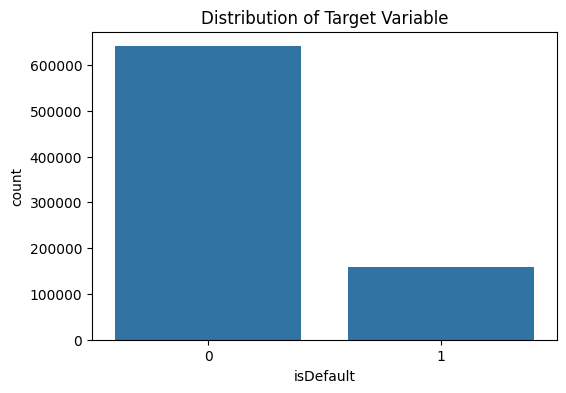

In [51]:
# 目标变量的分布
plt.figure(figsize=(6,4))
sns.countplot(x='isDefault', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

###### 各个特征与目标变量的关系

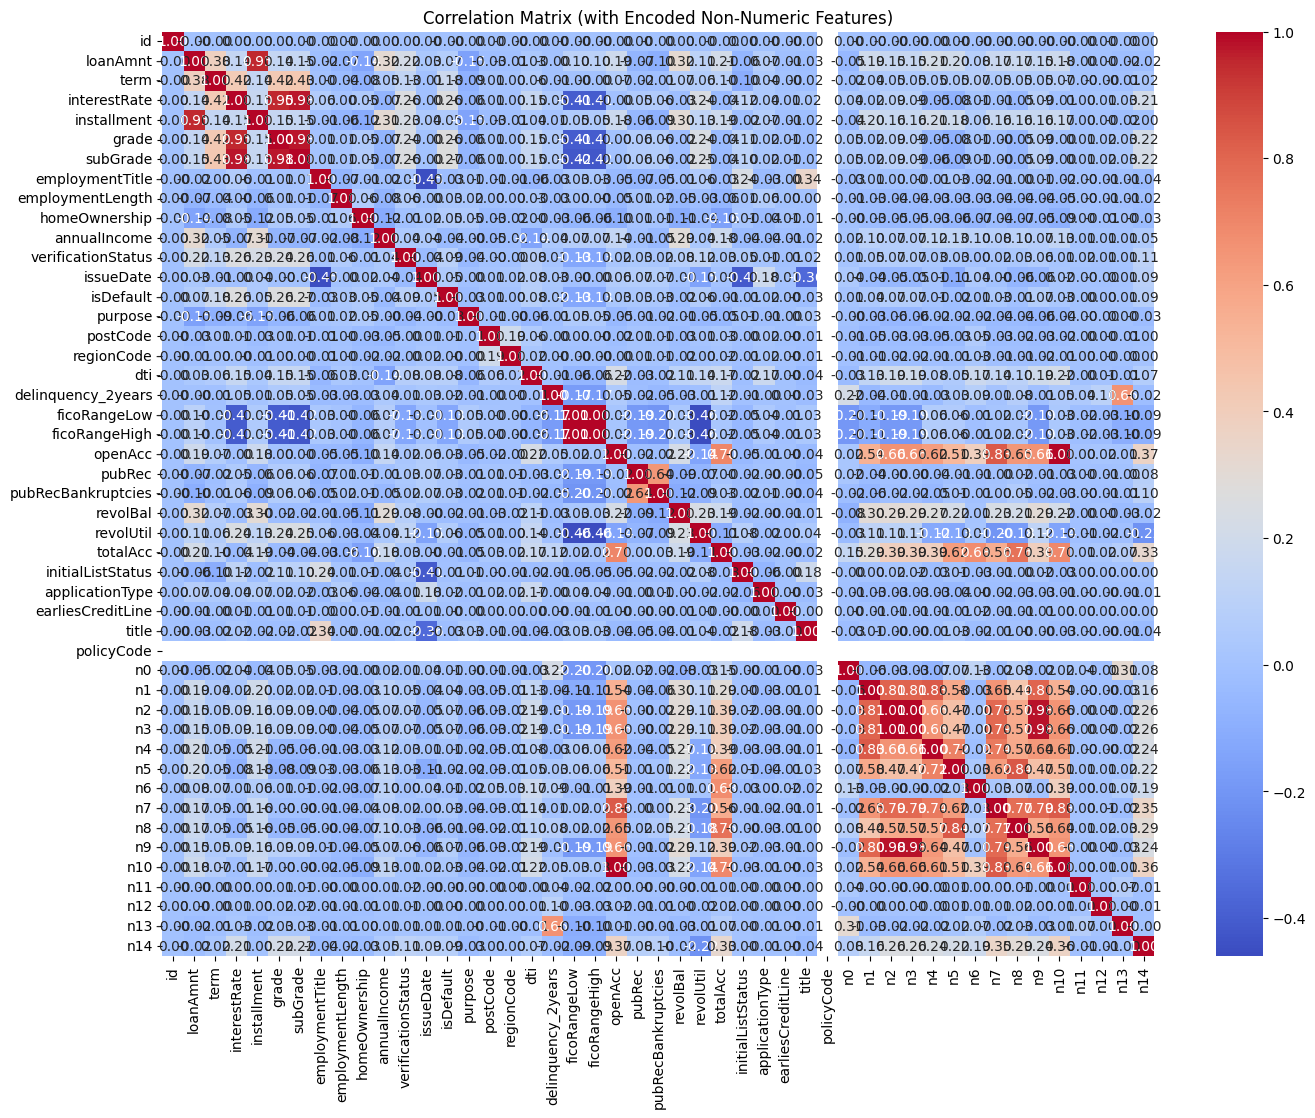

In [52]:
# 创建一个副本以避免对原始数据修改
encoded_data = train_data.copy()

# 对非数值列进行 LabelEncoder 编码
label_encoders = {}
for col in encoded_data.select_dtypes(exclude=[np.number]).columns:
    le = LabelEncoder()
    # 处理空值：先填充一个特殊字符，如 'Missing'
    encoded_data[col] = encoded_data[col].fillna('Missing')
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le  # 可选：保存编码器以便反编码

# 相关性热力图
plt.figure(figsize=(16, 12))
sns.heatmap(encoded_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (with Encoded Non-Numeric Features)')
plt.show()

# 删除copy变量
del encoded_data

###### 匿名列与目标变量的关系

isDefault    1.000000
n14          0.085715
n3           0.070352
n2           0.070352
n9           0.068978
n1           0.040659
n7           0.032007
n10          0.025583
n4           0.013156
n0           0.010953
n13          0.010101
n6           0.005350
n12          0.003287
n11         -0.000293
n8          -0.005951
n5          -0.018661
Name: isDefault, dtype: float64


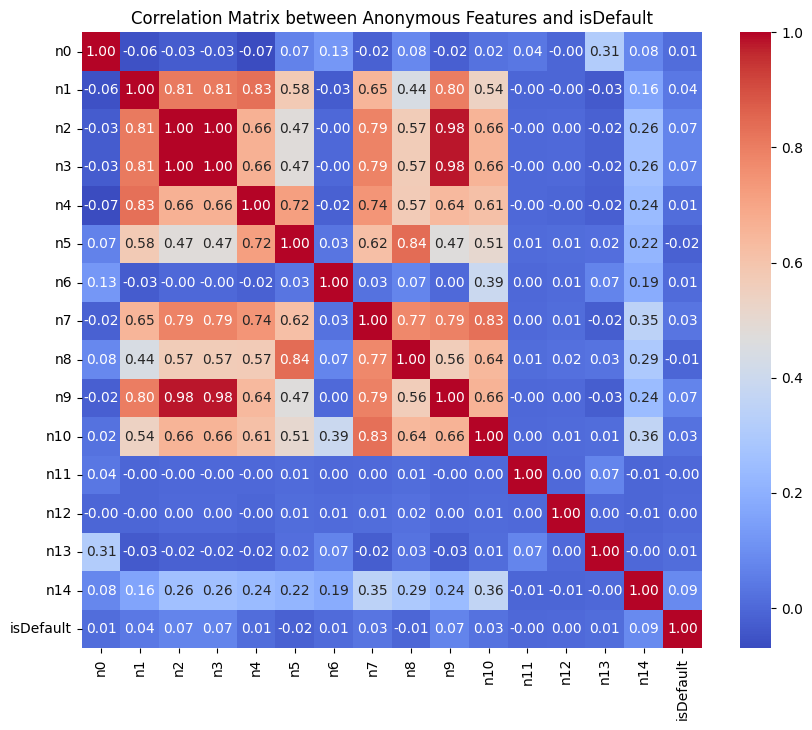

In [53]:
# 选择匿名列 + 目标列
anon_cols = [f"n{i}" for i in range(15)]
cols_to_check = anon_cols + ['isDefault']
df_corr = train_data[cols_to_check].corr()

# 显示 isDefault 的相关性部分
print(df_corr['isDefault'].sort_values(ascending=False))

# 可视化热力图
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Anonymous Features and isDefault")
plt.show()

## 数据预处理

In [54]:
# 数据预处理
def preprocess_data(df):
    
    # 处理数值变量的缺失值
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    
    # 处理分类变量的缺失值
    cat_cols = df.select_dtypes(include=['object']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    
    # 处理分类变量编码
    for column in cat_cols:
        df[column] = LabelEncoder().fit_transform(df[column])
    
    return df

In [55]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

## 特征工程

In [56]:
# 特征选择和数据标准化
X = train_data.drop(columns=['id', 'isDefault'])
y = train_data['isDefault']
X_test = test_data.drop(columns=['id'])

In [ ]:
# 特征选择：选择与目标变量相关性绝对值大于0的特征
corr_matrix = train_data.corr()
high_corr_features = corr_matrix.index[abs(corr_matrix["isDefault"]) > 0.00]
X = train_data[high_corr_features].drop(columns=['isDefault'])
X_test = test_data[high_corr_features.drop('isDefault')]

In [58]:
# 保存特征名称
feature_names = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

## 分割训练集

In [59]:
# 分割训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 使用较小的数据子集来调试和验证各种模型
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

## 寻找最合适的模型

#### 决策树模型

In [60]:
# 决策树模型
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_small, y_train_small)
y_val_pred_dt = dt_model.predict_proba(X_val)[:, 1]
auc_score_dt = roc_auc_score(y_val, y_val_pred_dt)
print(f'Decision Tree Validation AUC Score: {auc_score_dt}')

Decision Tree Validation AUC Score: 0.6983838197754868


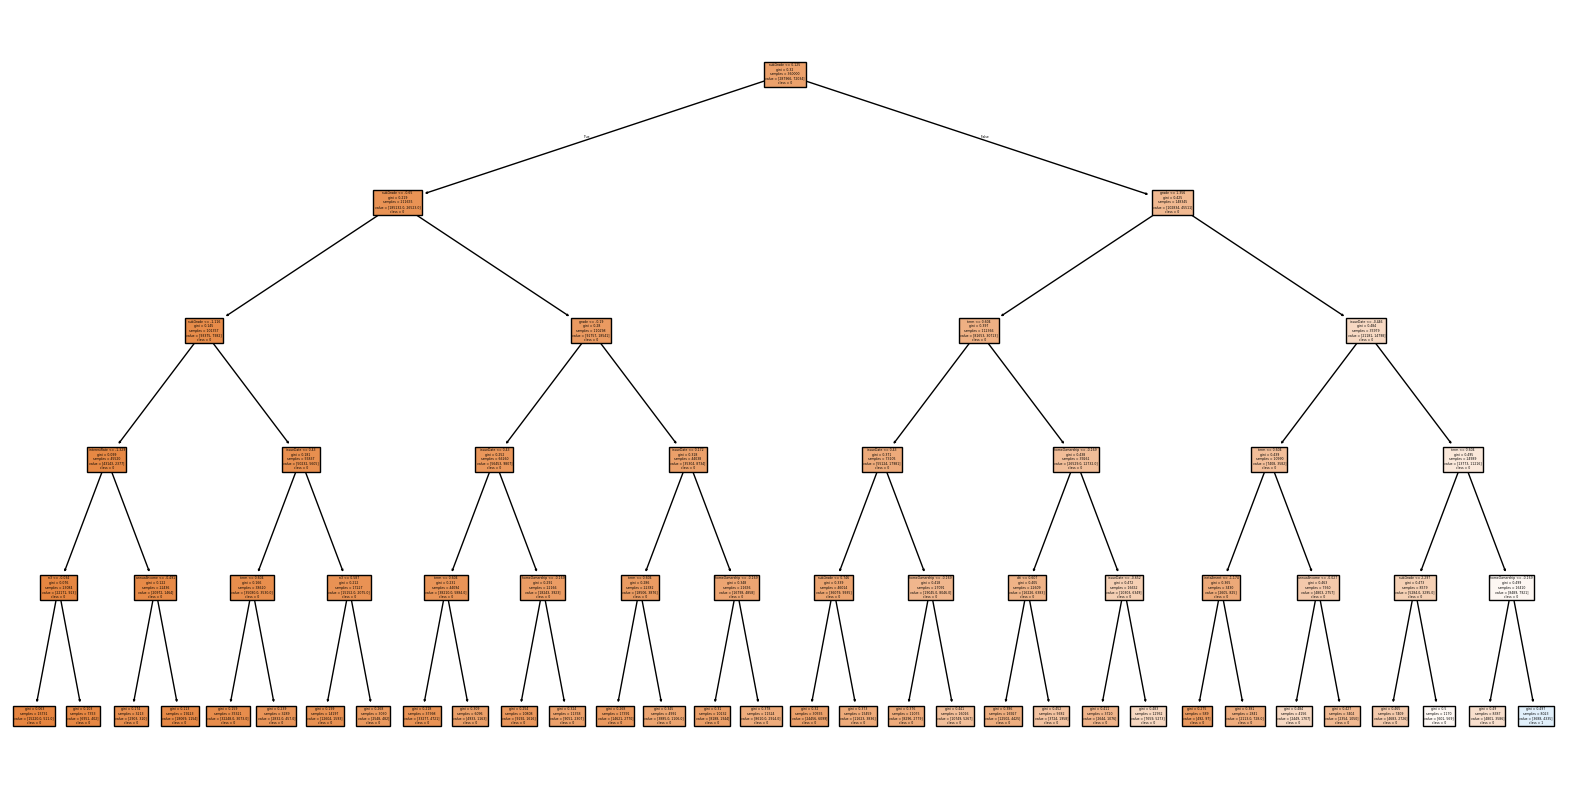

In [61]:
# 可视化决策树
plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=feature_names, class_names=['0', '1'])
plt.show()

#### KNN模型

In [62]:
# KNN模型
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_small, y_train_small)
y_val_pred_knn = knn_model.predict_proba(X_val)[:, 1]
auc_score_knn = roc_auc_score(y_val, y_val_pred_knn)
print(f'KNN Validation AUC Score: {auc_score_knn}')

KNN Validation AUC Score: 0.6172673244387012


In [63]:
# 耗时较久，且结果不佳因此直接放弃
# auc_score_knn = 0

#### XGBoost模型

In [64]:
# XGBoost模型
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_small, y_train_small)
y_val_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
auc_score_xgb = roc_auc_score(y_val, y_val_pred_xgb)
print(f'XGBoost Validation AUC Score: {auc_score_xgb}')

c:\Users\20716\Desktop\copy\virtualenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:14:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation AUC Score: 0.7256854901912728


#### LightGBM模型

In [65]:
# LightGBM模型
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_small, y_train_small)
y_val_pred_lgb = lgb_model.predict_proba(X_val)[:, 1]
auc_score_lgb = roc_auc_score(y_val, y_val_pred_lgb)
print(f'LightGBM Validation AUC Score: {auc_score_lgb}')

[LightGBM] [Info] Number of positive: 72034, number of negative: 287966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4204
[LightGBM] [Info] Number of data points in the train set: 360000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200094 -> initscore=-1.385704
[LightGBM] [Info] Start training from score -1.385704
LightGBM Validation AUC Score: 0.7290376283879269


c:\Users\20716\Desktop\copy\virtualenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### CatBoost模型

In [66]:
# 指定类别型特征的列名或索引
# cat_cols = [col for col in train_data.columns if X_train[col].dtype == 'object' or 'category' in str(train_data[col].dtype)]
# cat_cols = feature_names.to_list()

# 创建模型
cat_model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    # cat_features=cat_cols,
    early_stopping_rounds=500,
    # custom_metric=['AUC', 'F1', 'Recall', 'Precision'],
    # class_weights = [1, 4], # 非违约:违约 = 1:4（经验值，20%违约率适合此比例）
    verbose=100
)

# 拟合模型
cat_model.fit(
    X_train_small, y_train_small,
    eval_set=(X_val, y_val),
    use_best_model=True,
)
# 预测验证集概率（违约概率）
y_val_pred_cat = cat_model.predict_proba(X_val)[:, 1]
# 计算 AUC
auc_score_cat = roc_auc_score(y_val, y_val_pred_cat)
print(f'CatBoost Validation AUC Score: {auc_score_cat}')

0:	test: 0.6933732	best: 0.6933732 (0)	total: 35ms	remaining: 1m 45s
100:	test: 0.7219839	best: 0.7219839 (100)	total: 3.47s	remaining: 1m 39s
200:	test: 0.7258848	best: 0.7258848 (200)	total: 6.74s	remaining: 1m 33s
300:	test: 0.7279310	best: 0.7279310 (300)	total: 9.91s	remaining: 1m 28s
400:	test: 0.7294211	best: 0.7294211 (400)	total: 19s	remaining: 2m 3s
500:	test: 0.7302186	best: 0.7302186 (500)	total: 28.1s	remaining: 2m 20s
600:	test: 0.7308576	best: 0.7308576 (600)	total: 30.9s	remaining: 2m 3s
700:	test: 0.7312258	best: 0.7312316 (697)	total: 33.8s	remaining: 1m 50s
800:	test: 0.7315237	best: 0.7315255 (799)	total: 36.9s	remaining: 1m 41s
900:	test: 0.7317819	best: 0.7317819 (900)	total: 40s	remaining: 1m 33s
1000:	test: 0.7320122	best: 0.7320123 (999)	total: 43.1s	remaining: 1m 26s
1100:	test: 0.7321978	best: 0.7321978 (1100)	total: 48.9s	remaining: 1m 24s
1200:	test: 0.7323291	best: 0.7323313 (1190)	total: 58.5s	remaining: 1m 27s
1300:	test: 0.7324377	best: 0.7324377 (1300)

#### 比较模型的效果，选择表现最好的模型

In [67]:
# 比较模型的效果，选择表现最好的模型
best_model = None
best_auc = max(auc_score_dt, auc_score_knn, auc_score_xgb, auc_score_lgb, auc_score_cat)

if best_auc == auc_score_dt:
    best_model = dt_model
elif best_auc == auc_score_knn:
    best_model = knn_model
elif best_auc == auc_score_xgb:
    best_model = xgb_model
elif best_auc == auc_score_cat:
    best_model = cat_model
else:
    best_model = lgb_model

print(f'Best Model is {best_model}')
print(f'Best Model AUC: {best_auc}')

Best Model is <catboost.core.CatBoostClassifier object at 0x000001CB56C522A0>
Best Model AUC: 0.7327242435982542


## 使用全量数据训练最佳模型

In [ ]:
# 指定类别型特征的列名或索引
cat_cols = [col for col in train_data.columns if train_data[col].dtype == 'object' or 'category' in str(train_data[col].dtype)]


# 重新创建模型(方便调参)
cat_model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    cat_features=cat_cols,
    early_stopping_rounds=5000,
    # custom_metric=['AUC', 'F1', 'Recall', 'Precision'],
    # class_weights = [1, 4], # 非违约:违约 = 1:4（经验值，20%违约率适合此比例）
    verbose=100
)

# 拟合模型
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
)

# 预测验证集概率（违约概率）
y_val_pred_cat = cat_model.predict_proba(X_val)[:, 1]

# 计算 AUC
auc_score_cat = roc_auc_score(y_val, y_val_pred_cat)
print(f'CatBoost Validation AUC Score: {auc_score_cat:.4f}')

0:	test: 0.6958059	best: 0.6958059 (0)	total: 51.3ms	remaining: 4m 16s
100:	test: 0.7228272	best: 0.7228272 (100)	total: 6.14s	remaining: 4m 58s
200:	test: 0.7268224	best: 0.7268224 (200)	total: 12.1s	remaining: 4m 49s
300:	test: 0.7289285	best: 0.7289285 (300)	total: 18.2s	remaining: 4m 44s
400:	test: 0.7303597	best: 0.7303597 (400)	total: 24.8s	remaining: 4m 44s
500:	test: 0.7313484	best: 0.7313489 (499)	total: 31.1s	remaining: 4m 39s
600:	test: 0.7321897	best: 0.7321897 (600)	total: 37.2s	remaining: 4m 32s
700:	test: 0.7328536	best: 0.7328548 (698)	total: 43.4s	remaining: 4m 25s
800:	test: 0.7332651	best: 0.7332651 (800)	total: 49.2s	remaining: 4m 17s
900:	test: 0.7337516	best: 0.7337516 (900)	total: 54.9s	remaining: 4m 9s
1000:	test: 0.7340665	best: 0.7340665 (1000)	total: 1m	remaining: 4m 2s
1100:	test: 0.7343998	best: 0.7344030 (1098)	total: 1m 6s	remaining: 3m 55s
1200:	test: 0.7347079	best: 0.7347079 (1200)	total: 1m 12s	remaining: 3m 49s
1300:	test: 0.7348573	best: 0.7348615 (

## 在测试集上进行预测

In [69]:
# 在测试集上进行预测
test_pred = cat_model.predict_proba(X_test)[:, 1]

## 结果提交

In [70]:
# 结果提交
submission = pd.DataFrame({'id': test_data['id'], 'isDefault': test_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully.")

Submission file created successfully.


## 交叉验证/超参优化（测试）

In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 读取数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('testA.csv')

# 预处理函数同你之前定义的
def preprocess_data(df):
    df = df.drop(columns=['postCode', 'n11', 'n12'])

    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

    cat_cols = df.select_dtypes(include=['object']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    for column in cat_cols:
        df[column] = LabelEncoder().fit_transform(df[column])

    return df

# 数据预处理
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# 特征和标签划分
X = train_data.drop(columns=['id', 'isDefault'])
y = train_data['isDefault']
X_test = test_data.drop(columns=['id'])

# CatBoost 分类模型超参数
params = {
    'iterations': 5000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 200
}

# 分类变量（注意：LabelEncoder 后不再需要 cat_features）
cat_features = []

# K折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
test_preds = np.zeros(len(X_test))

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostClassifier(**params)

    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              use_best_model=True)

    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)

    print(f"Fold {fold+1} AUC: {auc:.4f}")

    # 累加测试集预测结果（用于平均）
    test_preds += model.predict_proba(X_test)[:, 1] / kf.n_splits

print("\nAverage AUC across folds:", np.mean(auc_scores))


Fold 1:


KeyboardInterrupt: 